# Autoencoders para la detección de anomalías cardiacas 

In [1]:
!git clone https://github.com/AcecomFCUNI/anomaly-ECG.git
%cd anomaly-ECG/data

Cloning into 'anomaly-ECG'...
remote: Enumerating objects: 16, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 16 (delta 0), reused 13 (delta 0), pack-reused 0
Unpacking objects: 100% (16/16), done.
/content/anomaly-ECG/data


## 1- El problema a resolver

Detectar la presencia (sujeto *anormal*) o ausencia (sujeto *normal*) de irregularidades en el ritmo cardiaco, a partir de señales electrocardiográficas (ECG):

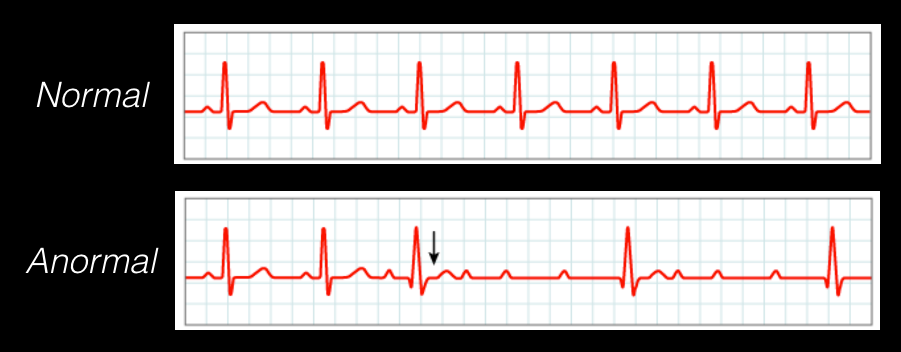

El problema es que usualmente se cuenta con sets de datos **desbalanceados** con más datos normales que anormales.

## 2- El set de datos

Se usará el set [ECG5000](https://timeseriesclassification.com/description.php?Dataset=ECG5000) con 7600 datos de entrenamiento y 1900 de prueba.

Cada dato contiene un ciclo cardiaco con 140 muestras, y que puede pertenecer a una de 5 categorías:

1. Normal
2. Anormal: contracción ventricular prematura
3. Anormal: contracción supra-ventricular prematura
4. Anormal: latido ectópico
5. Anormal pero patología desconocida

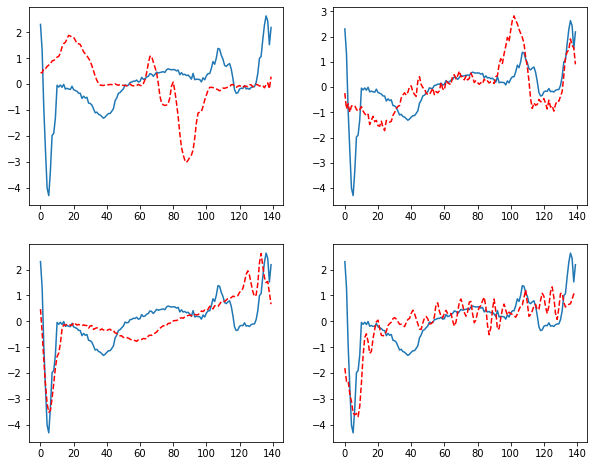


## 3- Autoencoders y detección de anomalías

El problema del set ECG5000 es que contiene 4427 datos normales y 3173 anormales, es decir está desbalanceado.

De hecho para ciertas categorías anormales (2 a 4) se tienen muy pocos datos:

| Categoría   | Nro. datos |
|-------------|------------|
| 1 (normal)  | 4427       |
| 2 (anormal) | 2683       |
| 3 (anormal) | 149        |
| 4 (anormal) | 306        |
| 5 (anormal) | 35         |

Así que en lugar de un modelo de clasificación convencional (como una Red Neuronal) se usará un [Autoencoder](https://www.codificandobits.com/blog/autoencoders-explicacion-y-tutorial-python/):

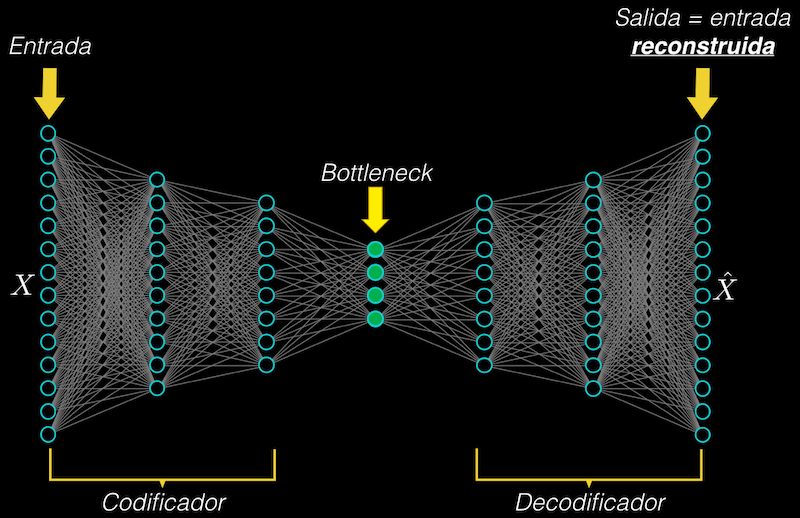

El autoencoder se entrenará **únicamente con datos normales**. Así, al reconstruir un dato anormal **el error será alto**.

## 4- Implementación

### 4.1. Lectura de los sets de entrenamiento y prueba

In [2]:
ruta = './'

import pandas as pd
df_train = pd.read_csv(ruta + 'ECG5000_train.csv')
df_test = pd.read_csv(ruta + 'ECG5000_test.csv')

In [3]:
print(df_train.shape)
print(df_test.shape)

(7600, 141)
(1900, 141)


In [4]:
df_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140
0,1,-1.30300,-0.83573,-1.9336,-2.09420,-2.02840,-1.2531,-0.52638,-0.089286,-0.07557,0.37087,0.56642,0.54261,0.66121,0.62479,0.74207,0.76770,0.81974,0.835750,0.76076,0.81097,0.81676,0.88772,0.89175,0.87736,0.88914,0.86543,0.89386,0.89202,0.85169,0.85788,0.83076,0.84067,0.861440,0.854430,0.802750,0.81368,0.82726,0.801690,0.810900,...,0.17621,0.21094,0.20356,0.12882,0.12110,0.060584,-0.036151,-0.15962,-0.36932,-0.48888,-0.72672,-0.99073,-1.13060,-1.28670,-1.24200,-1.28720,-1.35690,-1.38860,-1.545400,-1.50300,-1.604700,-1.56360,-1.61090,-1.664700,-1.83510,-1.84900,-1.83060,-1.780300,-1.74310,-1.45550,-1.45820,-1.6676,-1.5977,-1.67930,-1.677200,-1.69370,-1.79410,-1.35940,-2.08120,-2.82880
1,2,0.32288,-0.87847,-1.8023,-2.66850,-3.26550,-3.3326,-2.88000,-2.227400,-1.54360,-0.97706,-0.76983,-0.70974,-0.28113,0.15679,0.38162,0.46802,0.43842,0.370230,0.23492,0.18923,0.24149,0.30124,0.29042,0.28200,0.23152,0.23147,0.23528,0.14181,0.22672,0.17502,0.17585,0.18336,0.092464,0.005377,-0.078705,0.03310,0.10339,-0.051258,0.002961,...,0.90389,0.98836,0.87212,0.90944,0.96901,0.947020,0.969250,0.96811,1.03100,1.02360,0.98695,0.97388,0.83435,0.91798,0.89487,0.98121,0.77954,0.60109,0.516780,0.43719,0.448180,0.30539,0.15175,-0.045591,-0.25836,-0.33189,-0.35901,-0.295970,-0.26956,-0.69683,-1.23050,-1.7218,-2.1953,-2.74890,-3.446500,-3.66210,-3.01820,-1.65140,-0.23670,0.82832
2,2,1.39340,1.59260,1.2420,0.79449,0.19577,-0.3156,-0.58053,-0.945020,-1.23350,-1.31790,-1.32820,-1.14270,-0.85536,-0.50753,-0.21569,-0.13837,-0.14210,-0.035537,0.28042,0.51453,0.53823,0.55477,0.53627,0.49089,0.49694,0.57934,0.64473,0.59247,0.53083,0.47033,0.45692,0.52115,0.511590,0.496170,0.556310,0.56821,0.53570,0.495200,0.435200,...,0.61854,0.62773,0.63470,0.64032,0.57703,0.596120,0.679180,0.61694,0.55551,0.60792,0.61381,0.60917,0.59986,0.56488,0.50019,0.36760,0.28932,0.25419,0.261390,0.22714,0.024193,-0.12737,-0.19262,-0.315870,-0.54165,-0.76463,-0.79023,-0.825690,-1.11350,-1.47640,-1.90850,-2.5295,-3.0614,-3.50370,-3.900400,-4.24600,-4.13380,-3.19850,-2.42200,-1.07370
3,1,-3.52270,-5.02610,-4.3613,-4.10570,-3.10420,-1.8178,-1.39840,-1.070100,-0.40691,-0.26780,-0.22567,-0.29459,-0.17663,-0.18777,-0.19646,-0.13372,-0.16795,-0.187070,-0.11136,-0.16066,-0.21886,-0.25888,-0.25794,-0.35207,-0.41271,-0.40929,-0.47057,-0.35898,-0.45973,-0.53768,-0.58698,-0.60378,-0.580350,-0.631020,-0.673070,-0.57797,-0.58204,-0.592550,-0.468730,...,1.56870,1.70360,1.60610,1.58610,1.58730,1.382100,1.194500,0.96238,0.83690,0.56481,0.27801,-0.06689,-0.15102,-0.13651,-0.19678,-0.16130,-0.17972,-0.18722,-0.238250,-0.23132,-0.233040,-0.24635,-0.16764,-0.102420,-0.22879,-0.16076,-0.14332,-0.070402,0.25943,0.63877,0.83038,1.0084,1.1830,0.94636,0.952130,0.79343,0.84741,1.01390,0.31234,-2.19060
4,1,-1.91820,-3.22510,-3.4652,-4.00800,-3.87030,-3.3581,-2.28540,-1.728500,-1.42220,-0.89887,-0.53819,-0.62751,-0.66393,-0.57033,-0.53109,-0.58764,-0.57940,-0.585400,-0.51963,-0.56812,-0.59811,-0.45864,-0.48240,-0.49757,-0.54754,-0.59650,-0.49290,-0.47874,-0.57125,-0.50545,-0.49044,-0.49744,-0.477910,-0.561750,-0.496130,-0.56496,-0.53351,-0.441470,-0.498320,...,1.74580,2.00800,2.00430,1.95470,1.87470,1.691500,1.487700,1.36550,1.12820,0.97613,0.71257,0.43090,0.21238,0.16481,0.15334,0.11062,0.13443,0.12413,0.092813,0.12983,0.188160,0.13241,0.15633,0.195670,0.23698,0.28418,0.25881,0.315700,0.65309,1.35350,1.77690,1.5029,1.1651,0.46073,0.019172,-0.32739,-0.48051,-0.18814,0.14284,-0.66844


In [5]:
df_train['0'].value_counts()

1    4427
2    2683
4     306
3     149
5      35
Name: 0, dtype: int64

### 4.2. Sets de entrenamiento y validación

In [6]:
# Pandas a arreglos numpy
datos_train = df_train.values
datos_test = df_test.values

# Etiquetas
cat_train = datos_train[:,0]
cat_test = datos_test[:,0]

# Subdivisión por categorías
x_train_1 = datos_train[cat_train==1,1:]
x_train_2 = datos_train[cat_train==2,1:]
x_train_3 = datos_train[cat_train==3,1:]
x_train_4 = datos_train[cat_train==4,1:]
x_train_5 = datos_train[cat_train==5,1:]

x_test_1 = datos_test[cat_test==1,1:]
x_test_2 = datos_test[cat_test==2,1:]
x_test_3 = datos_test[cat_test==3,1:]
x_test_4 = datos_test[cat_test==4,1:]
x_test_5 = datos_test[cat_test==5,1:]

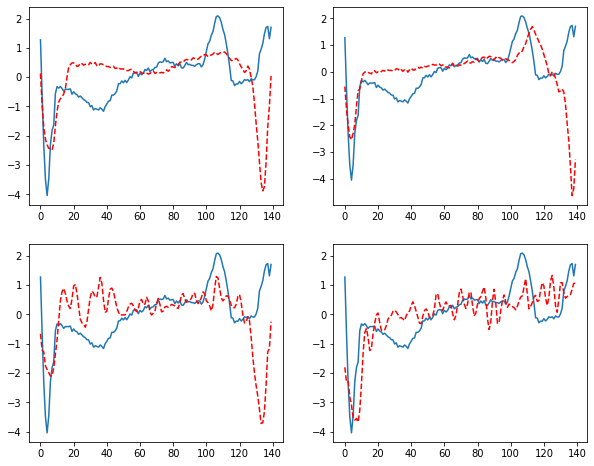

In [7]:
# Dibujar un dato normal y uno de cada anormal
import matplotlib.pyplot as plt
import numpy as np

ind = 10
normal = x_train_1[ind]
anormal_2 = x_train_2[ind]
anormal_3 = x_train_3[ind]
anormal_4 = x_train_4[ind]
anormal_5 = x_train_5[ind]

plt.figure(figsize=(10,8))
plt.grid()
plt.subplot(2,2,1)
plt.plot(np.arange(140), normal)
plt.plot(np.arange(140), anormal_2, 'r--')
plt.subplot(2,2,2)
plt.plot(np.arange(140), normal)
plt.plot(np.arange(140), anormal_3, 'r--')
plt.subplot(2,2,3)
plt.plot(np.arange(140), normal)
plt.plot(np.arange(140), anormal_4, 'r--')
plt.subplot(2,2,4)
plt.plot(np.arange(140), normal)
plt.plot(np.arange(140), anormal_5, 'r--')

### 4.3. Preprocesamiento (normalización)

In [8]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()

x_train_1_s = min_max_scaler.fit_transform(x_train_1)
print('Mínimo y máximo originales: {:.1f}, {:.1f}'.format(np.min(x_train_1), np.max(x_train_1)))
print('Mínimo y máximo normalización: {:.1f}, {:.1f}'.format(np.min(x_train_1_s), np.max(x_train_1_s)))

x_test_1_s = min_max_scaler.transform(x_test_1)
x_test_2_s = min_max_scaler.transform(x_test_2)
x_test_3_s = min_max_scaler.transform(x_test_3)
x_test_4_s = min_max_scaler.transform(x_test_4)
x_test_5_s = min_max_scaler.transform(x_test_5)

Mínimo y máximo originales: -7.1, 5.0
Mínimo y máximo normalización: 0.0, 1.0


### 4.4. Creación del Autoencoder en TensorFlow/Keras

In [9]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
np.random.seed(23)

dim_entrada = x_train_1_s.shape[1]    #140 muestras/ejemplo
entrada = Input(shape=(dim_entrada,))

# Encoder
encoder = Dense(32, activation='relu')(entrada)
encoder = Dense(16, activation='relu')(encoder)
encoder = Dense(8, activation='relu')(encoder)

# Decoder
decoder = Dense(16, activation='relu')(encoder)
decoder = Dense(32, activation='relu')(decoder)
decoder = Dense(140, activation='sigmoid')(decoder)

# Autoencoder = entrada + decoder (que ya contiene el encoder)
autoencoder = Model(inputs=entrada, outputs=decoder)

autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 140)]             0         
_________________________________________________________________
dense (Dense)                (None, 32)                4512      
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 16)                144       
_________________________________________________________________
dense_4 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_5 (Dense)              (None, 140)               4620  

### 4.5. Optimización y entrenamiento

La pérdida será el error absoluto medio (*Mean Absolute Error*, MAE):

$MAE = \frac{\sum_{i=1}^{140} |x_i - \hat{x_i}|}{140}$

In [10]:
autoencoder.compile(optimizer='adam', loss='mae')
historia = autoencoder.fit(x_train_1_s, x_train_1_s, 
          epochs=20, 
          batch_size=512,
          validation_data=(x_test_1_s, x_test_1_s),
          shuffle=True)

Epoch 1/20
9/9 [==============================] - 3s 21ms/step - loss: 0.1258 - val_loss: 0.1218
Epoch 2/20
9/9 [==============================] - 0s 5ms/step - loss: 0.1168 - val_loss: 0.1100
Epoch 3/20
9/9 [==============================] - 0s 5ms/step - loss: 0.1042 - val_loss: 0.0972
Epoch 4/20
9/9 [==============================] - 0s 5ms/step - loss: 0.0919 - val_loss: 0.0860
Epoch 5/20
9/9 [==============================] - 0s 5ms/step - loss: 0.0819 - val_loss: 0.0776
Epoch 6/20
9/9 [==============================] - 0s 5ms/step - loss: 0.0747 - val_loss: 0.0721
Epoch 7/20
9/9 [==============================] - 0s 5ms/step - loss: 0.0702 - val_loss: 0.0688
Epoch 8/20
9/9 [==============================] - 0s 5ms/step - loss: 0.0676 - val_loss: 0.0666
Epoch 9/20
9/9 [==============================] - 0s 5ms/step - loss: 0.0657 - val_loss: 0.0651
Epoch 10/20
9/9 [==============================] - 0s 5ms/step - loss: 0.0643 - val_loss: 0.0639
Epoch 11/20
9/9 [=====================

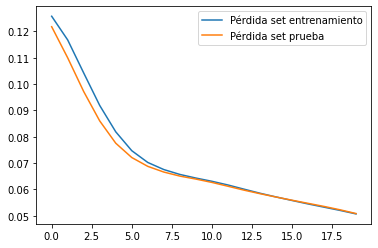

In [11]:
plt.plot(historia.history["loss"], label="Pérdida set entrenamiento")
plt.plot(historia.history["val_loss"], label="Pérdida set prueba")
plt.legend()

## 5- Clasificación

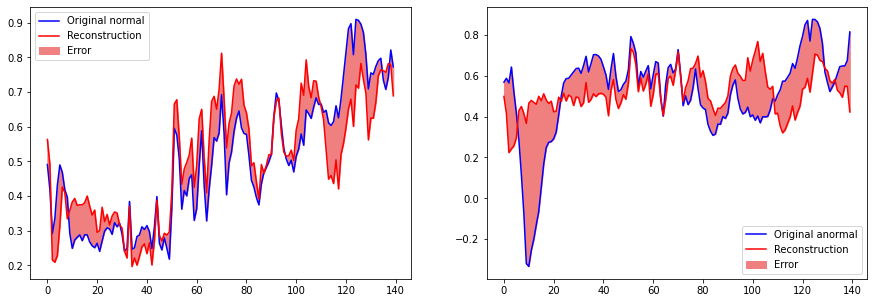

In [12]:
# ¿Qué tan bien reconstruye un dato "normal" y uno anormal?
rec_normal = autoencoder(x_test_1_s).numpy()
rec_anormal = autoencoder(x_test_5_s).numpy()

dato = 5
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(x_test_1_s[dato],'b')
plt.plot(rec_normal[dato],'r')
plt.fill_between(np.arange(140), rec_normal[dato], x_test_1_s[dato], color='lightcoral')
plt.legend(labels=["Original normal", "Reconstruction", "Error"])
plt.subplot(1,2,2)
plt.plot(x_test_5_s[dato],'b')
plt.plot(rec_anormal[dato],'r')
plt.fill_between(np.arange(140), rec_anormal[dato], x_test_5_s[dato], color='lightcoral')
plt.legend(labels=["Original anormal", "Reconstruction", "Error"])

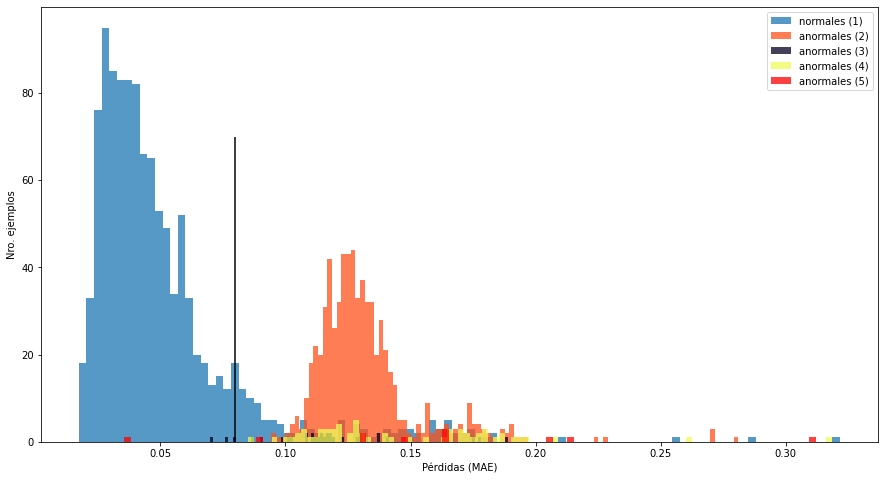

In [13]:
# Distribuciones de los errores de construcción
# para cada categoría

import tensorflow as tf

rec_1 = autoencoder.predict(x_test_1_s)
rec_2 = autoencoder.predict(x_test_2_s)
rec_3 = autoencoder.predict(x_test_3_s)
rec_4 = autoencoder.predict(x_test_4_s)
rec_5 = autoencoder.predict(x_test_5_s)

loss_1 = tf.keras.losses.mae(rec_1, x_test_1_s)
loss_2 = tf.keras.losses.mae(rec_2, x_test_2_s)
loss_3 = tf.keras.losses.mae(rec_3, x_test_3_s)
loss_4 = tf.keras.losses.mae(rec_4, x_test_4_s)
loss_5 = tf.keras.losses.mae(rec_5, x_test_5_s)


plt.figure(figsize=(15,8))
plt.hist(loss_1[None,:], bins=100, alpha=0.75, label='normales (1)')
plt.hist(loss_2[None,:], bins=100, alpha=0.75, color='#ff521b', label='anormales (2)')
plt.hist(loss_3[None,:], bins=100, alpha=0.75, color='#020122', label='anormales (3)')
plt.hist(loss_4[None,:], bins=100, alpha=0.75, color='#eefc57', label='anormales (4)')
plt.hist(loss_5[None,:], bins=100, alpha=0.75, color='r', label='anormales (5)')
plt.xlabel('Pérdidas (MAE)')
plt.ylabel('Nro. ejemplos')
plt.legend(loc='upper right')
plt.vlines(0.08,0,70,'k')



In [14]:
umbral = np.mean(loss_1) + np.std(loss_1)
print("Umbral: ", umbral)

Umbral:  0.08247727946419989


### 5.1. Sensitividad y especificidad

- Verdaderos positivos (TP): anormales que han sido correctamente clasificados como anormales
- Falsos negativos (FN): anormales que han sido clasificados erróneamente como normales
- Verdaderos negativos (TN): normales que han sido correctamente clasificados como normales
- Falsos positivos (FP): normales que han sido clasificados erróneamente como anormales

La **sensitividad** mide la proporción de anormales que fueron detectados correctamente como anormales. Una sensitividad del 100% detectará a todos los pacientes enfermos:

$sensitividad = \frac{TP}{TP+FN}$

La **especificidad** mide la proporción de normales que fueron detectados correctamente como normales. Una especificidad del 100% detectará a todos los pacientes sanos:

$especificidad = \frac{TN}{TN+FP}$

In [15]:
# Calcular predicciones individuales
def predecir(modelo, datos, umbral):
  reconstrucciones = modelo(datos)
  perdida = tf.keras.losses.mae(reconstrucciones, datos)
  return tf.math.less(perdida, umbral)

def calcular_sensitividad(prediccion, titulo):
  TP = np.count_nonzero(~prediccion)
  FN = np.count_nonzero(prediccion)
  sen = 100*(TP/(TP+FN))

  print(titulo + ': {:.1f}%'.format(sen))

def calcular_especificidad(prediccion, titulo):
  TN = np.count_nonzero(prediccion)
  FP = np.count_nonzero(~prediccion)
  esp = 100*(TN/(TN+FP))

  print(titulo + ': {:.1f}%'.format(esp))
  return esp

In [16]:
# Predicciones
pred_1 = predecir(autoencoder, x_test_1_s, umbral)
pred_2 = predecir(autoencoder, x_test_2_s, umbral)
pred_3 = predecir(autoencoder, x_test_3_s, umbral)
pred_4 = predecir(autoencoder, x_test_4_s, umbral)
pred_5 = predecir(autoencoder, x_test_5_s, umbral)

# Pred1: especificidad
esp_1 = calcular_especificidad(pred_1,'Especificidad (cat. 1, normales)')

# Pred 2 a 5: sensitividad
sen_2 = calcular_sensitividad(pred_2,'Sensitividad (cat. 2, anormales)')
sen_3 = calcular_sensitividad(pred_3,'Sensitividad (cat. 3, anormales)')
sen_4 = calcular_sensitividad(pred_4,'Sensitividad (cat. 4, anormales)')
sen_5 = calcular_sensitividad(pred_3,'Sensitividad (cat. 5, anormales)')

Especificidad (cat. 1, normales): 89.9%
Sensitividad (cat. 2, anormales): 100.0%
Sensitividad (cat. 3, anormales): 90.9%
Sensitividad (cat. 4, anormales): 100.0%
Sensitividad (cat. 5, anormales): 90.9%
